### 국가 탐색
- 국가별 영화 개수를 확인하라. (Bar chart)
### 출연배우 탐색
- 가장 많은 영화에 주연으로 출연한 배우를 찾아라.
- 조연으로 가장 많은 영화에 출연한 배우를 찾아라.
- 주연으로 출연한 영화(5편 이상 출연)들의 평균 평점이 가장 높은 영화(평점 10개 이상)의 주연 배우를 찾아라. (상위 3개 영화 등 조건을 변경할 수 있게 처리)

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정 (맑은 고딕)
from matplotlib import rc
rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

# 데이터 로드
movies = pd.read_csv('kmrd-small/movies.txt', sep="\t", engine='python')
countries = pd.read_csv('kmrd-small/countries.csv')
castings = pd.read_csv('kmrd-small/castings.csv')
users = pd.read_csv('kmrd-small/rates.csv')
peoples = pd.read_csv('kmrd-small/peoples.txt', sep="\t", engine='python')
genres = pd.read_csv('kmrd-small/genres.csv')


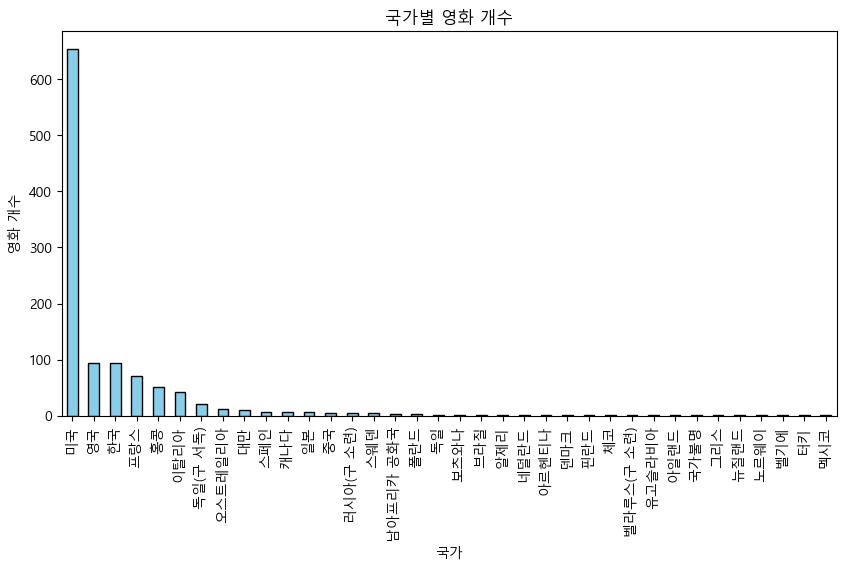

In [3]:
# 국가별 영화 개수 확인 (Bar chart)
country_counts = countries['country'].value_counts()
plt.figure(figsize=(10, 5))
country_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('국가별 영화 개수')
plt.xlabel('국가')
plt.ylabel('영화 개수')
plt.show()

In [4]:
# 가장 많은 영화에 주연으로 출연한 배우

# 주연 배우 필터링
leading_castings = castings[castings['leading'] == 1]

# 주연 출연 횟수 계산
leading_counts = leading_castings['people'].value_counts().reset_index()
# leading_counts.columns = ['people', 'count']

# print(leading_counts)
# print(leading_counts.columns)

# 배우 이름(한글)과 병합
leading_counts = leading_counts.merge(peoples[['people', 'korean']], on='people', how='left')

# 가장 많은 출연 배우 정보 추출
top_leading_actor = leading_counts.iloc[0]

print("---주연으로 가장 많은 출연---")
print(f"people 번호: {top_leading_actor['people']}")
print(f"배우 한글명: {top_leading_actor['korean']}")
print(f"출연영화 수: {top_leading_actor['count']}")


---주연으로 가장 많은 출연---
people 번호: 1327
배우 한글명: 로버트 드 니로
출연영화 수: 16


In [5]:
# 가장 많은 영화에 조연으로 출연한 배우

# 조연인 배우 필터링
supporting_castings = castings[castings['leading'] == 0]

# 조연 배우별 출연 횟수 계산
supporting_counts = supporting_castings['people'].value_counts().reset_index()
# supporting_counts.columns = ['people', 'count']

# 배우 이름(한글)과 병합
supporting_counts = supporting_counts.merge(peoples[['people', 'korean']], on='people', how='left')

# 출연 횟수가 가장 많은 조연 배우 정보 추출
top_supporting_actor = supporting_counts.iloc[0]

print("---조연으로 가장 많은 출연---")
print(f"피플 번호: {top_supporting_actor['people']}")
print(f"배우 한글명: {top_supporting_actor['korean']}")
print(f"출연영화 수: {top_supporting_actor['count']}")


---조연으로 가장 많은 출연---
피플 번호: 2248
배우 한글명: 우마
출연영화 수: 9


In [6]:
pip show ipywidgets

Name: ipywidgets
Version: 8.1.5
Summary: Jupyter interactive widgets
Home-page: http://jupyter.org
Author: Jupyter Development Team
Author-email: jupyter@googlegroups.com
License: BSD 3-Clause License
Location: c:\Users\SWJ\AppData\Local\Programs\Python\Python312\Lib\site-packages
Requires: comm, ipython, jupyterlab-widgets, traitlets, widgetsnbextension
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [28]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output

# 1. 평점이 10개 이상인 영화에
# 2. 5번 이상 주연으로 출연한
# 3. 배우 리스트

def calculate_high_rated_actors(top_n):
    # 1. 영화별 평점 계산 (평점 개수가 10개 이상인 영화 필터링)
    movie_ratings = users.groupby('movie').agg(
        average_rating=('rate', 'mean'),
        rating_count=('rate', 'count')
    ).reset_index()
    high_rated_movies = movie_ratings[movie_ratings['rating_count'] >= 10]

    # 2. 주연 필터링 (leading == 1)
    leading_castings = castings[castings['leading'] == 1]

    # 3. 주연 배우와 평점 조건을 충족하는 영화 병합
    leading_high_rated = pd.merge(leading_castings, high_rated_movies, on='movie', how='inner')

    # 4. 배우별 조건 확인 (10개 이상의 평점이 달린 영화에 주연으로 출연한 영화 5편 이상)
    actor_movie_counts = leading_high_rated['people'].value_counts()
    valid_actors = actor_movie_counts[actor_movie_counts >= 5].index

    # 5. 조건에 맞는 배우 정보 추출
    result = leading_high_rated[leading_high_rated['people'].isin(valid_actors)]
    result = result.merge(peoples, on='people', how='left')

    # 6. 상위 N명의 배우 추출
    if not result.empty:
        top_actors = result.groupby('people').agg(
            korean=('korean', 'first'),
            movie_count=('movie', 'count'),
        ).sort_values(by='movie_count', ascending=False).head(top_n)

        print(f"상위 {top_n}명의 배우:")
        display(top_actors)
    else:
        print("조건을 충족하는 배우가 없습니다.")

# 슬라이더 생성 및 연결
top_n_slider = widgets.IntSlider(
    value=3,  # 초기값
    min=1,    # 최소값
    max=10,   # 최대값
    step=1,   # 단계
    description='상위 배우 수:'
)

# 업데이트 함수
def update_top_n(change):
    clear_output(wait=True)  # 이전 출력 지우기
    display(top_n_slider)    # 슬라이더 다시 표시
    calculate_high_rated_actors(top_n=top_n_slider.value)

top_n_slider.observe(update_top_n, names='value')

# 위젯 표시 및 초기 실행
display(top_n_slider)
calculate_high_rated_actors(top_n=top_n_slider.value)


IntSlider(value=10, description='상위 배우 수:', max=10, min=1)

상위 10명의 배우:


,korean,movie_count
people,,
1843,안성기,11
1507,실베스터 스탤론,11
99,아놀드 슈왈제네거,10
535,해리슨 포드,10
1327,로버트 드 니로,10
1422,숀 코네리,9
1068,마이클 더글라스,8
1994,주윤발,8
1822,성룡,8
